header

# Introduction

## Business case

Explain the problem space and business case.

## Import packages and load data

In [1]:
# Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet as proph

In [2]:
# Read in the data
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Drop columns that definitely aren't needed
oregon = df[df.State == 'OR']
oregon.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
# Check number of OR zipcodes
len(oregon)

224

In [5]:
# Back-fill any missing values
oregon = oregon.fillna(method='bfill')

In [6]:
# Check that NaNs are all resolved (should print nothing)
for col in oregon.columns:
    if oregon.isna().sum()[col] > 0:
        print(col)

## Create custom functions

In [7]:
def melt_data(df):
    melted = pd.melt(df, var_name='ds')
    melted['ds'] = pd.to_datetime(melted['ds'], infer_datetime_format=True)
    melted.set_index('ds', inplace=True)

    return melted

# Identify top 5 zipcodes for investment in Oregon

Explain motivation and the methods to be used to determine which are the top zipcodes.

## Greatest net gain 1996-2018

In [8]:
oregon_copy = oregon.copy()
oregon_copy.fillna(oregon_copy.bfill())
oregon_copy['growth'] = oregon_copy['2018-04'] - oregon_copy['1996-04']
top_10_growth_all = oregon_copy.sort_values('growth', ascending=False)[:10]
top_10_growth_all

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,growth
6338,97210,Portland,OR,Portland,Multnomah,312400.0,315600.0,318800.0,321700.0,324700.0,...,990900,992500,990500,988700,992700,1000700,1006900,1006500,1000700,688300.0
7372,97205,Portland,OR,Portland,Multnomah,345900.0,348200.0,350400.0,352600.0,354900.0,...,958800,956200,952600,952000,959300,967500,971600,973800,970900,625000.0
3887,97201,Portland,OR,Portland,Multnomah,351700.0,353100.0,354500.0,355900.0,357300.0,...,937200,936900,933000,931600,933800,938100,941300,939800,935100,583400.0
5153,97034,Lake Oswego,OR,Portland,Clackamas,252000.0,253000.0,254100.0,255200.0,256600.0,...,753400,760000,769600,778000,786100,791300,801700,816200,824600,572600.0
5713,97232,Portland,OR,Portland,Multnomah,174100.0,175300.0,176500.0,177700.0,178900.0,...,677000,678600,680300,682300,686600,692200,696500,695500,690600,516500.0
3776,97212,Portland,OR,Portland,Multnomah,163400.0,164800.0,166200.0,167600.0,169100.0,...,654400,653800,652500,653200,656200,659800,661700,660200,656100,492700.0
2557,97214,Portland,OR,Portland,Multnomah,136700.0,137700.0,138800.0,139900.0,141000.0,...,591500,590000,587100,586200,589400,593800,597200,598000,596300,459600.0
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,524900,527300,531100,534600,537100,540300,543600,543300,540300,455800.0
11103,97231,Portland,OR,Portland,Multnomah,174700.0,176300.0,177800.0,179300.0,180800.0,...,595500,598000,601000,602400,601500,601100,599200,595200,594200,419500.0
5968,97215,Portland,OR,Portland,Multnomah,134400.0,135400.0,136400.0,137400.0,138400.0,...,528300,528800,529600,531000,533800,536900,540400,542300,541400,407000.0


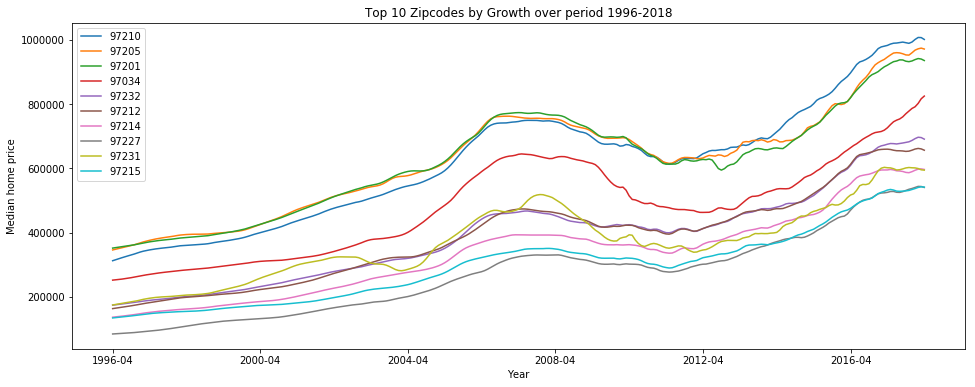

In [9]:
xticks = ['1996-04', '2000-04', '2004-04', '2008-04', '2012-04', '2016-04']
plt.figure(figsize=(16,6))
for index in top_10_growth_all.index:
    sample = top_10_growth_all.loc[index,'1996-04':'2018-04']
    zipcode = top_10_growth_all.loc[index]['RegionName']
    plt.plot(sample, label=top_10_growth_all.loc[index]['RegionName'])
plt.xticks(xticks)
plt.legend()
plt.title('Top 10 Zipcodes by Growth over period 1996-2018')
plt.ylabel('Median home price')
plt.xlabel('Year')
plt.show();

## Greatest net gain 2008-2018

In [10]:
oregon_copy = oregon.copy()
oregon_copy.fillna(oregon_copy.bfill())
oregon_copy['growth'] = oregon_copy['2018-04'] - oregon_copy['2008-04']
top_10_growth_10 = oregon_copy.sort_values('growth', ascending=False)[:10]
top_10_growth_10

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,growth
6338,97210,Portland,OR,Portland,Multnomah,312400.0,315600.0,318800.0,321700.0,324700.0,...,990900,992500,990500,988700,992700,1000700,1006900,1006500,1000700,256200.0
5713,97232,Portland,OR,Portland,Multnomah,174100.0,175300.0,176500.0,177700.0,178900.0,...,677000,678600,680300,682300,686600,692200,696500,695500,690600,238200.0
7372,97205,Portland,OR,Portland,Multnomah,345900.0,348200.0,350400.0,352600.0,354900.0,...,958800,956200,952600,952000,959300,967500,971600,973800,970900,217500.0
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,524900,527300,531100,534600,537100,540300,543600,543300,540300,209700.0
2557,97214,Portland,OR,Portland,Multnomah,136700.0,137700.0,138800.0,139900.0,141000.0,...,591500,590000,587100,586200,589400,593800,597200,598000,596300,205100.0
3776,97212,Portland,OR,Portland,Multnomah,163400.0,164800.0,166200.0,167600.0,169100.0,...,654400,653800,652500,653200,656200,659800,661700,660200,656100,194400.0
5968,97215,Portland,OR,Portland,Multnomah,134400.0,135400.0,136400.0,137400.0,138400.0,...,528300,528800,529600,531000,533800,536900,540400,542300,541400,192400.0
5153,97034,Lake Oswego,OR,Portland,Clackamas,252000.0,253000.0,254100.0,255200.0,256600.0,...,753400,760000,769600,778000,786100,791300,801700,816200,824600,191100.0
999,97202,Portland,OR,Portland,Multnomah,132600.0,133400.0,134200.0,135000.0,135800.0,...,523400,522700,521700,522200,525700,530100,534100,535900,535000,186000.0
2520,97211,Portland,OR,Portland,Multnomah,88000.0,88700.0,89400.0,90200.0,91000.0,...,458200,457500,456400,456100,458800,463200,468000,472300,474300,178400.0


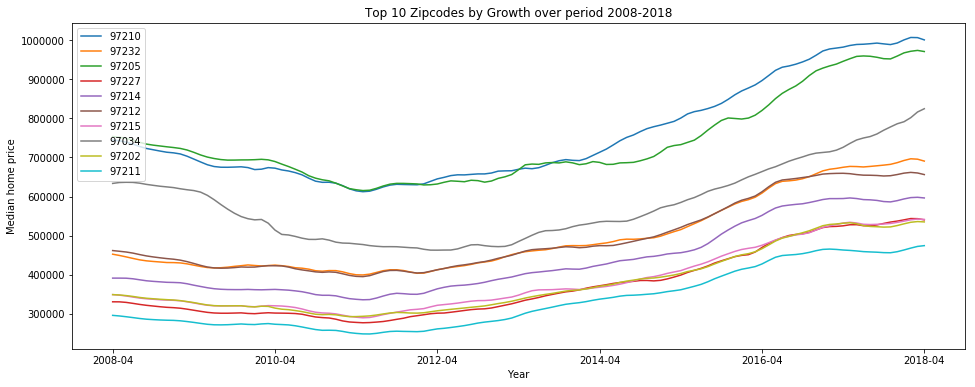

In [11]:
xticks = ['2008-04', '2010-04', '2012-04', '2014-04', '2016-04', '2018-04']
plt.figure(figsize=(16,6))
for index in top_10_growth_10.index:
    sample = top_10_growth_10.loc[index,'2008-04':'2018-04']
    zipcode = top_10_growth_10.loc[index]['RegionName']
    plt.plot(sample, label=top_10_growth_10.loc[index]['RegionName'])
plt.xticks(xticks)
plt.legend()
plt.title('Top 10 Zipcodes by Growth over period 2008-2018')
plt.ylabel('Median home price')
plt.xlabel('Year')
plt.show();

## Greatest net gain 2013-2018

In [12]:
oregon_copy = oregon.copy()
oregon_copy.fillna(oregon_copy.bfill())
oregon_copy['growth'] = oregon_copy['2018-04'] - oregon_copy['2013-04']
top_10_growth_5 = oregon_copy.sort_values('growth', ascending=False)[:10]
top_10_growth_5

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,growth
5153,97034,Lake Oswego,OR,Portland,Clackamas,252000.0,253000.0,254100.0,255200.0,256600.0,...,753400,760000,769600,778000,786100,791300,801700,816200,824600,339700.0
6338,97210,Portland,OR,Portland,Multnomah,312400.0,315600.0,318800.0,321700.0,324700.0,...,990900,992500,990500,988700,992700,1000700,1006900,1006500,1000700,331100.0
3887,97201,Portland,OR,Portland,Multnomah,351700.0,353100.0,354500.0,355900.0,357300.0,...,937200,936900,933000,931600,933800,938100,941300,939800,935100,304200.0
7372,97205,Portland,OR,Portland,Multnomah,345900.0,348200.0,350400.0,352600.0,354900.0,...,958800,956200,952600,952000,959300,967500,971600,973800,970900,302500.0
2803,97703,Bend,OR,Bend,Deschutes,185900.0,185800.0,185600.0,185400.0,185400.0,...,561900,567700,570100,571000,571500,572100,573500,577400,581000,236500.0
5713,97232,Portland,OR,Portland,Multnomah,174100.0,175300.0,176500.0,177700.0,178900.0,...,677000,678600,680300,682300,686600,692200,696500,695500,690600,235100.0
3640,97035,Lake Oswego,OR,Portland,Clackamas,211100.0,212000.0,213100.0,214400.0,215900.0,...,571400,574200,576100,576700,579400,583400,588800,594600,598000,217600.0
11103,97231,Portland,OR,Portland,Multnomah,174700.0,176300.0,177800.0,179300.0,180800.0,...,595500,598000,601000,602400,601500,601100,599200,595200,594200,215800.0
12950,97753,Powell Butte,OR,Prineville,Crook,165700.0,165800.0,165900.0,165900.0,165900.0,...,494500,497400,499400,504500,510800,511500,512600,519300,524500,212800.0
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,524900,527300,531100,534600,537100,540300,543600,543300,540300,210300.0


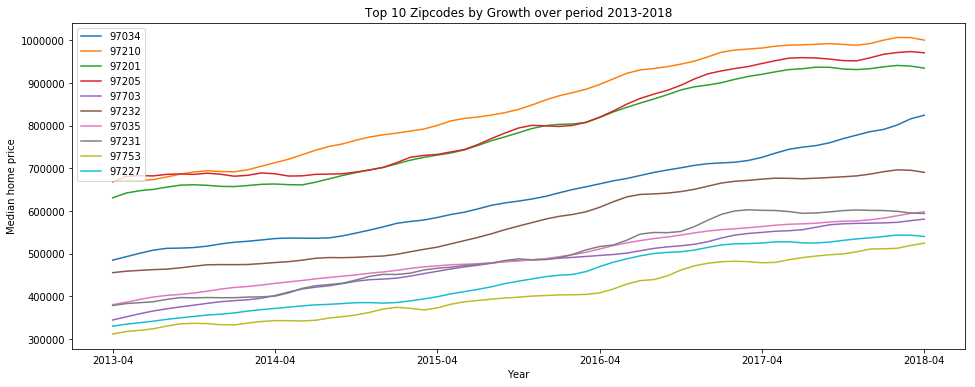

In [13]:
xticks = ['2013-04', '2014-04', '2015-04', '2016-04', '2017-04', '2018-04']
plt.figure(figsize=(16,6))
for index in top_10_growth_5.index:
    sample = top_10_growth_5.loc[index,'2013-04':'2018-04']
    zipcode = top_10_growth_5.loc[index]['RegionName']
    plt.plot(sample, label=top_10_growth_5.loc[index]['RegionName'])
plt.xticks(xticks)
plt.legend()
plt.title('Top 10 Zipcodes by Growth over period 2013-2018')
plt.ylabel('Median home price')
plt.xlabel('Year')
plt.show();

## Grab the top 5 zips

In [14]:
top_zips = list(top_10_growth_all.RegionName) + list(top_10_growth_10.RegionName) + list(top_10_growth_5.RegionName)

top_zips

[97210,
 97205,
 97201,
 97034,
 97232,
 97212,
 97214,
 97227,
 97231,
 97215,
 97210,
 97232,
 97205,
 97227,
 97214,
 97212,
 97215,
 97034,
 97202,
 97211,
 97034,
 97210,
 97201,
 97205,
 97703,
 97232,
 97035,
 97231,
 97753,
 97227]

In [15]:
zip_counts = {}

for zipcode in top_zips:
    zip_counts[zipcode] = zip_counts.get(zipcode, 0) + 1
    if zip_counts[zipcode] == 3:
        print(zipcode)


97034
97210
97205
97232
97227


In [16]:
top5_zips = ['97034', '97210', '97205', '97232', '97227']

top_data = oregon[oregon.RegionName.isin(top5_zips)]
top_data

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5153,97034,Lake Oswego,OR,Portland,Clackamas,252000.0,253000.0,254100.0,255200.0,256600.0,...,749700,753400,760000,769600,778000,786100,791300,801700,816200,824600
5713,97232,Portland,OR,Portland,Multnomah,174100.0,175300.0,176500.0,177700.0,178900.0,...,675600,677000,678600,680300,682300,686600,692200,696500,695500,690600
6338,97210,Portland,OR,Portland,Multnomah,312400.0,315600.0,318800.0,321700.0,324700.0,...,989600,990900,992500,990500,988700,992700,1000700,1006900,1006500,1000700
7372,97205,Portland,OR,Portland,Multnomah,345900.0,348200.0,350400.0,352600.0,354900.0,...,959600,958800,956200,952600,952000,959300,967500,971600,973800,970900
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,525300,524900,527300,531100,534600,537100,540300,543600,543300,540300


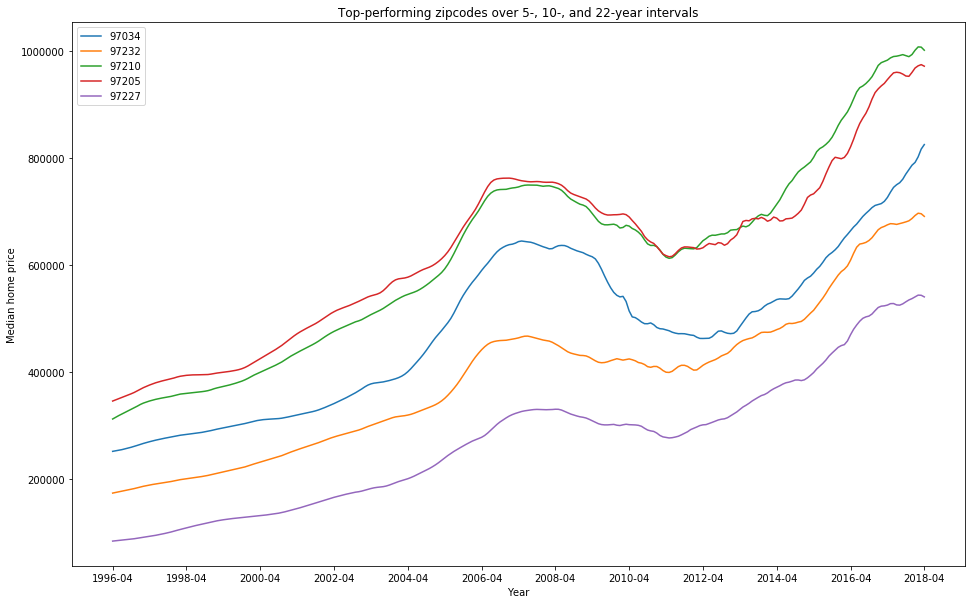

In [17]:
xticks = ['1996-04', '1998-04', '2000-04', '2002-04', '2004-04', '2006-04', 
          '2008-04', '2010-04', '2012-04', '2014-04', '2016-04', '2018-04']
plt.figure(figsize=(16,10))
for index in top_data.index:
    sample = top_data.loc[index,'1996-04':'2018-04']
    zipcode = top_data.loc[index]['RegionName']
    plt.plot(sample, label=top_data.loc[index]['RegionName'])
plt.xticks(xticks)
plt.legend()
plt.title('Top-performing zipcodes over 5-, 10-, and 22-year intervals')
plt.ylabel('Median home price')
plt.xlabel('Year')
plt.show();

## Least loss during recession (Jan. 2007 v. Jun. 2011)

Do this step to select from among the longer list generated by the previous steps. Basically, see which of the high-growth zips lost the least value during the recession.

In [18]:
oregon_copy = oregon.copy()

oregon_copy['rec_loss'] = np.abs(oregon_copy['2011-06'] - oregon_copy['2007-01'])
least_rec_loss = oregon_copy.sort_values('rec_loss', ascending=False)
least_rec_loss['rank'] = least_rec_loss['rec_loss'].rank()
least_rec_loss

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,rec_loss,rank
2803,97703,Bend,OR,Bend,Deschutes,185900.0,185800.0,185600.0,185400.0,185400.0,...,567700,570100,571000,571500,572100,573500,577400,581000,207100.0,224.0
8849,97759,Sisters,OR,Bend,Deschutes,139900.0,140700.0,141600.0,142300.0,143000.0,...,408500,409500,410100,410900,411100,414700,423000,429300,203100.0,223.0
12950,97753,Powell Butte,OR,Prineville,Crook,165700.0,165800.0,165900.0,165900.0,165900.0,...,497400,499400,504500,510800,511500,512600,519300,524500,200700.0,222.0
8953,97760,Terrebonne,OR,Roseburg,Jefferson,93400.0,93400.0,93400.0,93400.0,93300.0,...,337200,341000,343300,344800,346100,346700,348700,351900,168800.0,221.0
5153,97034,Lake Oswego,OR,Portland,Clackamas,252000.0,253000.0,254100.0,255200.0,256600.0,...,760000,769600,778000,786100,791300,801700,816200,824600,163400.0,220.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12987,97883,Union,OR,La Grande,Union,78400.0,78900.0,79400.0,79800.0,80200.0,...,144200,145200,147000,148800,149900,150500,151900,153400,3800.0,5.0
8743,97370,Philomath,OR,Corvallis,Benton,69300.0,69700.0,70000.0,70300.0,70600.0,...,281300,284400,287100,290100,292900,293000,291800,291500,3300.0,4.0
14523,97886,Weston,OR,Hermiston-Pendleton,Umatilla,107000.0,107600.0,108300.0,108900.0,109600.0,...,138000,138700,138700,139600,140500,141200,142700,143800,2400.0,3.0
13765,97868,Pilot Rock,OR,Hermiston-Pendleton,Umatilla,175300.0,176400.0,177500.0,178500.0,179500.0,...,123100,124400,124900,125500,126300,128000,130800,132600,1200.0,2.0


In [19]:
top_zips_least_loss = least_rec_loss[least_rec_loss.RegionName.isin(top5_zips)]
top_zips_least_loss[['RegionName','rank']]

,RegionName,rank
5153,97034,220.0
7372,97205,214.0
6338,97210,210.0
5713,97232,117.5
10068,97227,45.0


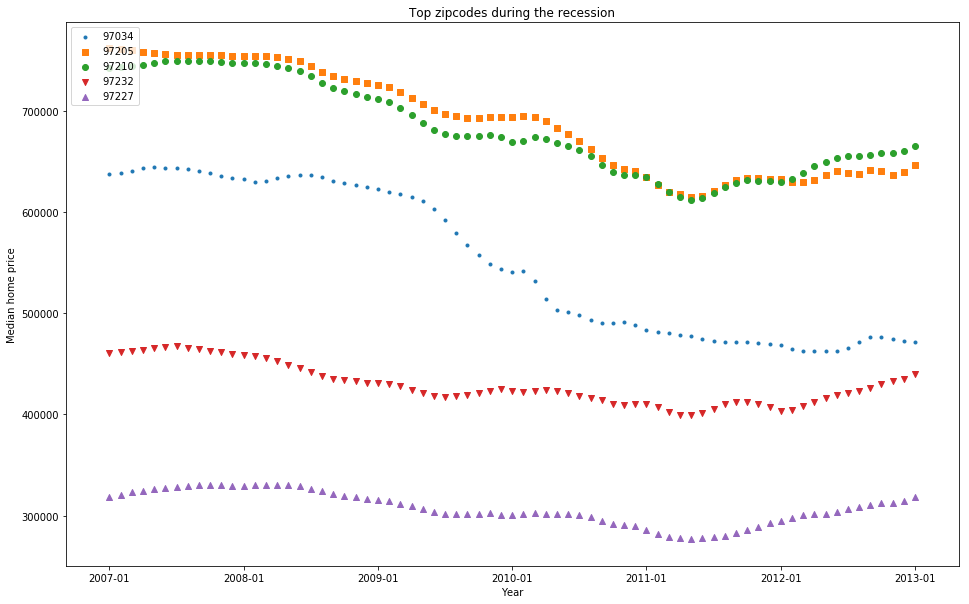

In [20]:
xticks = ['2007-01', '2008-01', '2009-01', '2010-01', '2011-01', '2012-01', '2013-01']
markers = ['.',',','o','v','^','<','>','1','2','3','4','8','p','P','*']
plt.figure(figsize=(16,10))
for n,index in enumerate(top_zips_least_loss.index):
    sample = top_zips_least_loss.loc[index,'2007-01':'2013-01']
    zipcode = top_zips_least_loss.loc[index]['RegionName']
    plt.scatter(sample.index, sample, marker=markers[n],
                label=top_zips_least_loss.loc[index]['RegionName'])
plt.xticks(xticks)
plt.legend(loc='upper left')
plt.title('Top zipcodes during the recession')
plt.ylabel('Median home price')
plt.xlabel('Year')
plt.show();

## Properties currently available

Bring in additional data for current number of properties listed on Zillow. Do this just for the winning zips.

In [21]:
listings = pd.read_csv('zillow_listings_counts.csv')
listings.head()

,SizeRank,RegionID,RegionName,RegionType,StateName,2013-01,2013-02,2013-03,2013-04,2013-05,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,1.0,61639,10025,Zip,NY,338.0,332.0,325.0,316.0,308.0,...,259.0,258.0,257.0,269.0,286.0,293.0,286.0,278.0,282.0,287
1,2.0,84654,60657,Zip,IL,510.0,503.0,484.0,483.0,483.0,...,491.0,510.0,504.0,495.0,518.0,545.0,564.0,580.0,579.0,574
2,3.0,61637,10023,Zip,NY,449.0,435.0,436.0,436.0,437.0,...,523.0,508.0,489.0,483.0,492.0,511.0,521.0,520.0,525.0,537
3,4.0,91982,77494,Zip,TX,948.0,932.0,889.0,860.0,835.0,...,941.0,962.0,947.0,934.0,958.0,972.0,962.0,948.0,908.0,875
4,5.0,84616,60614,Zip,IL,584.0,566.0,525.0,500.0,499.0,...,629.0,644.0,665.0,699.0,739.0,743.0,724.0,714.0,698.0,690


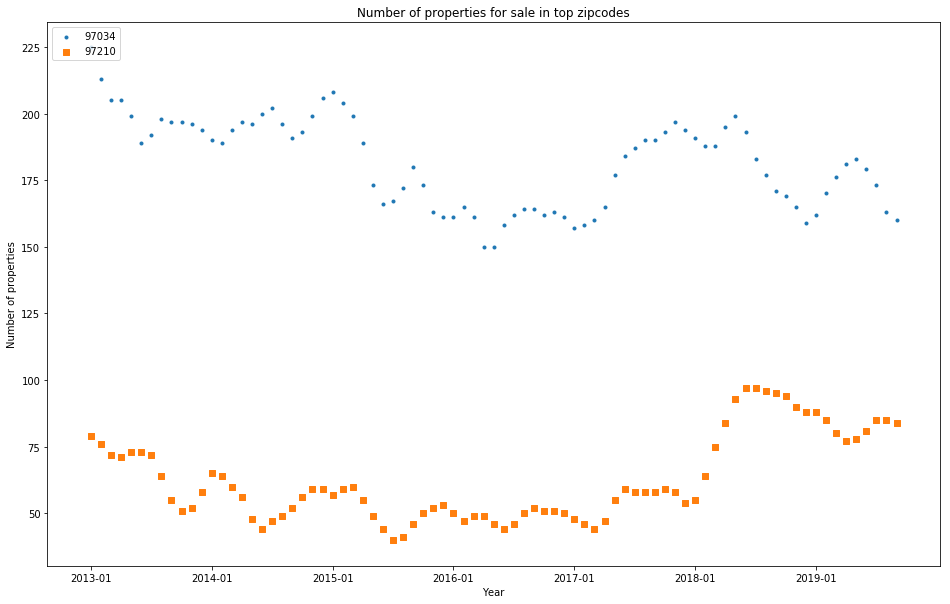

In [22]:
top_listings = listings[listings.RegionName.isin(top5_zips)]
xticks = ['2013-01', '2014-01', '2015-01', '2016-01', '2017-01', '2018-01', '2019-01']
markers = ['.',',','o','v','^','<','>','1','2','3','4','8','p','P','*']
plt.figure(figsize=(16,10))
for n,index in enumerate(top_listings.index):
    sample = top_listings.loc[index,'2013-01':'2019-09']
    zipcode = top_listings.loc[index]['RegionName']
    plt.scatter(sample.index, sample, marker=markers[n], label=zipcode)
plt.xticks(xticks)
plt.legend(loc='upper left')
plt.title('Number of properties for sale in top zipcodes')
plt.ylabel('Number of properties')
plt.xlabel('Year')
plt.show();

## The top 5 zipcodes

The top five zipcodes for investment in Oregon are 97034, 97232, 97210, 97205, and 97227. The ranking of these five depends on the investor's priorities and risk tolerance. 

All five zipcodes were in the top 10 for growth over 5-year, 10-year, and 22-year periods (going back as far as the data allows). This means that these areas have long histories of increasing median home prices. Barring unforeseen circumstances that radically change the desirability of these areas, we can expect that median home prices will continue to grow.

In [23]:
top_5 = ['97034', '97232', '97210', '97205', '97227']
avails = [160, 55, 84, 39, 11]
rec_ranks = [214, 113.5, 204, 208, 44]
top_5_data = oregon[oregon.RegionName.isin(top_5)]
top_5_data['rec_loss'] = top_5_data['2011-06'] - top_5_data['2007-01']
top_5_data['rec_rank'] = [x for x in rec_ranks]
top_5_data['avails'] = [x for x in avails]
top_5_data

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,rec_loss,rec_rank,avails
5153,97034,Lake Oswego,OR,Portland,Clackamas,252000.0,253000.0,254100.0,255200.0,256600.0,...,769600,778000,786100,791300,801700,816200,824600,-163400.0,214.0,160
5713,97232,Portland,OR,Portland,Multnomah,174100.0,175300.0,176500.0,177700.0,178900.0,...,680300,682300,686600,692200,696500,695500,690600,-59000.0,113.5,55
6338,97210,Portland,OR,Portland,Multnomah,312400.0,315600.0,318800.0,321700.0,324700.0,...,990500,988700,992700,1000700,1006900,1006500,1000700,-128900.0,204.0,84
7372,97205,Portland,OR,Portland,Multnomah,345900.0,348200.0,350400.0,352600.0,354900.0,...,952600,952000,959300,967500,971600,973800,970900,-145900.0,208.0,39
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,531100,534600,537100,540300,543600,543300,540300,-40400.0,44.0,11


There are varying numbers of investment opportunities in the five zipcodes, as represented by the number of properties listed on Zillow in September or October 2019. 
- Lake Oswego (97034) has the most available properties: 160.
- Portland (97227) has the fewest available properties: 11. 

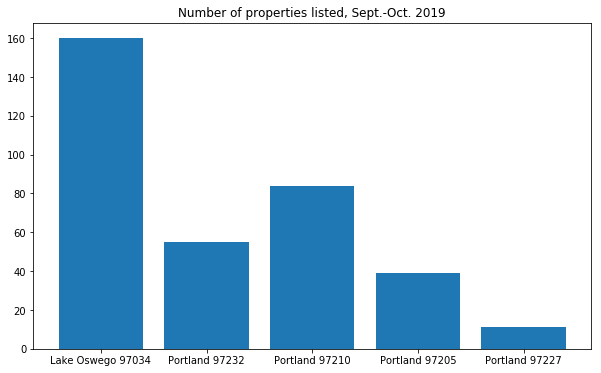

In [24]:
xticks = ['Lake Oswego 97034', 'Portland 97232', 'Portland 97210', 
          'Portland 97205', 'Portland 97227']
plt.figure(figsize=(10,6))
plt.bar(xticks, top_5_data.avails)
plt.xticks(xticks)
plt.title('Number of properties listed, Sept.-Oct. 2019')
plt.show();

During the Great Recession and the accompanying housing market crisis, some of these zipcodes fared better than others in terms of the decrease in median home price. I compared median prices in January 2007 (before the crisis set in) to June 2011 (around the low point for each of these zipcodes) and found how they ranked in terms of value lost (from smallest decrease in median home price to largest). 
- 97227 ranked 44th in Oregon and was the best of these five zipcodes, with a decrease in median home price of \$40,400. 
- 97034 ranked 214th out of 224 in Oregon and was the worst of these five zipcodes, with a decrease in median home price of \$163,400. 

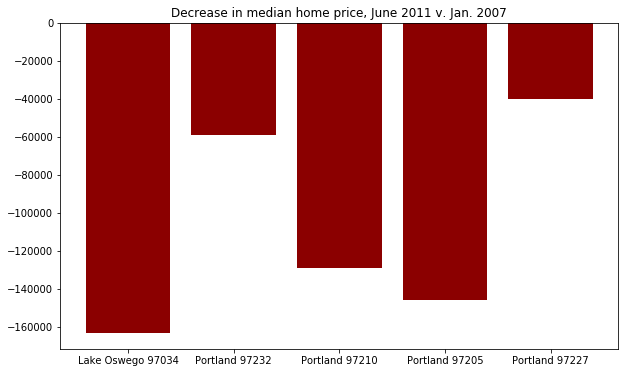

In [25]:
plt.figure(figsize=(10,6))
plt.bar(xticks, top_5_data.rec_loss, color='darkred')
plt.xticks(xticks)
plt.title('Decrease in median home price, June 2011 v. Jan. 2007')
plt.show();

Finally, investors may want to make their choice based on price point. The barplot below summarizes the most recent median price data available (April 2018). Below, I will forecast new values for these zipcodes, so take these values as our baseline.

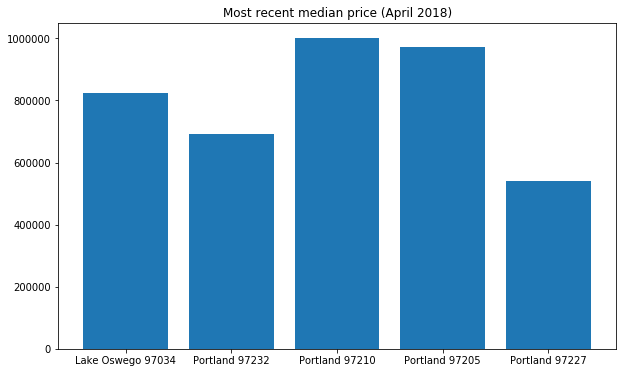

In [26]:
plt.figure(figsize=(10,6))
plt.bar(xticks, top_5_data['2018-04'])
plt.xticks(xticks)
plt.title('Most recent median price (April 2018)')
plt.show();

# Extract time series for top 5 zipcodes

In [27]:
or_trimmed = oregon.drop(['City','Metro','State','CountyName'], axis=1)

or_97034 = or_trimmed[or_trimmed.RegionName==97034].drop('RegionName', axis=1)
or_97232 = or_trimmed[or_trimmed.RegionName==97232].drop('RegionName', axis=1)
or_97210 = or_trimmed[or_trimmed.RegionName==97210].drop('RegionName', axis=1)
or_97205 = or_trimmed[or_trimmed.RegionName==97205].drop('RegionName', axis=1)
or_97227 = or_trimmed[or_trimmed.RegionName==97227].drop('RegionName', axis=1)
    

In [28]:
# This isn't working for some reason
# for data in [or_97034, or_97232, or_97210, or_97205, or_97227]:
#     data = data.melt(var_name='date')
#     data['date'] = pd.to_datetime(data['date'], format='%Y-%m')
#     data.set_index('date', inplace=True)


# EDA and visualization

w/r/t time

## 97034

In [29]:
or_97034 = melt_data(or_97034)
or_97034

,value
ds,
1996-04-01,252000.0
1996-05-01,253000.0
1996-06-01,254100.0
1996-07-01,255200.0
1996-08-01,256600.0
...,...
2017-12-01,786100.0
2018-01-01,791300.0
2018-02-01,801700.0


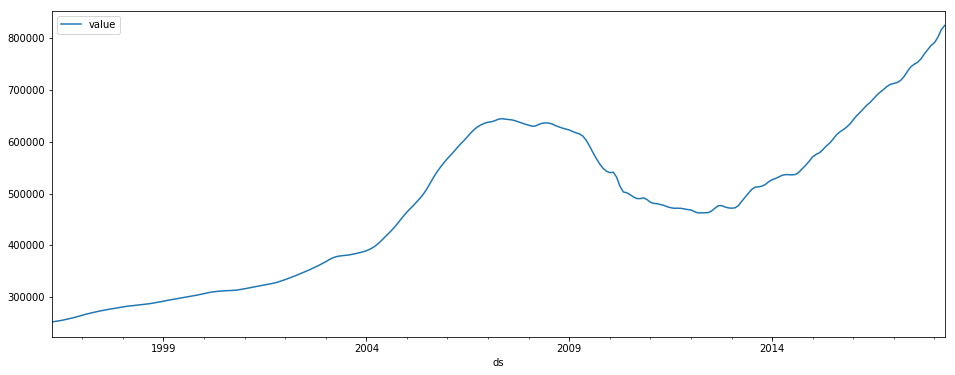

In [30]:
or_97034.plot(figsize=(16,6));

## 97232

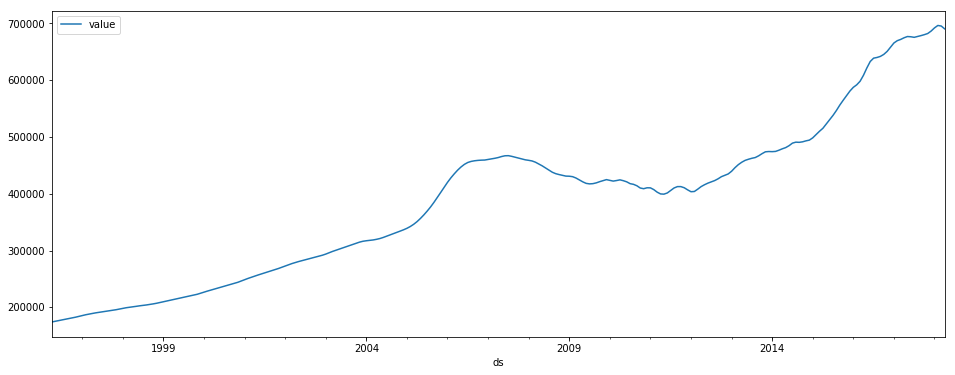

In [31]:
or_97232 = melt_data(or_97232)
or_97232.plot(figsize=(16,6));

In [32]:
or_97232

,value
ds,
1996-04-01,174100.0
1996-05-01,175300.0
1996-06-01,176500.0
1996-07-01,177700.0
1996-08-01,178900.0
...,...
2017-12-01,686600.0
2018-01-01,692200.0
2018-02-01,696500.0


## 97210

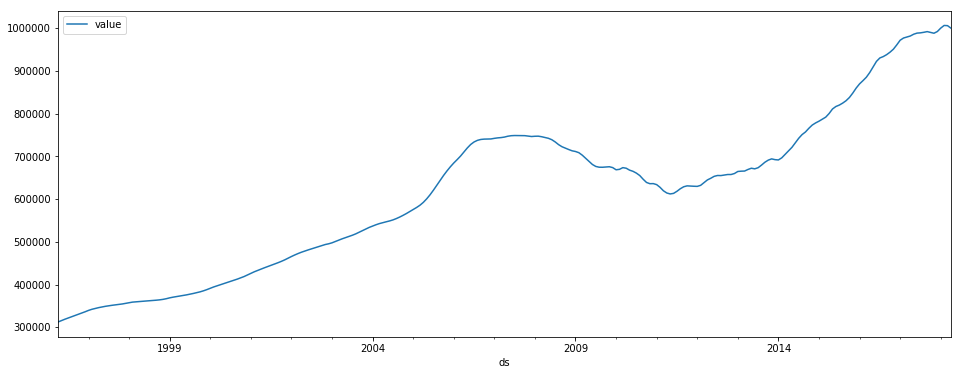

In [33]:
or_97210 = melt_data(or_97210)
or_97210.plot(figsize=(16,6));

## 97205

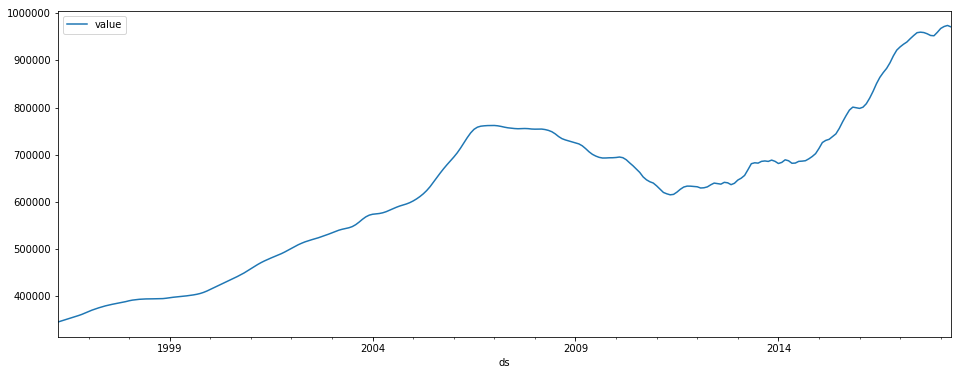

In [34]:
or_97205 = melt_data(or_97205)
or_97205.plot(figsize=(16,6));

## 97227

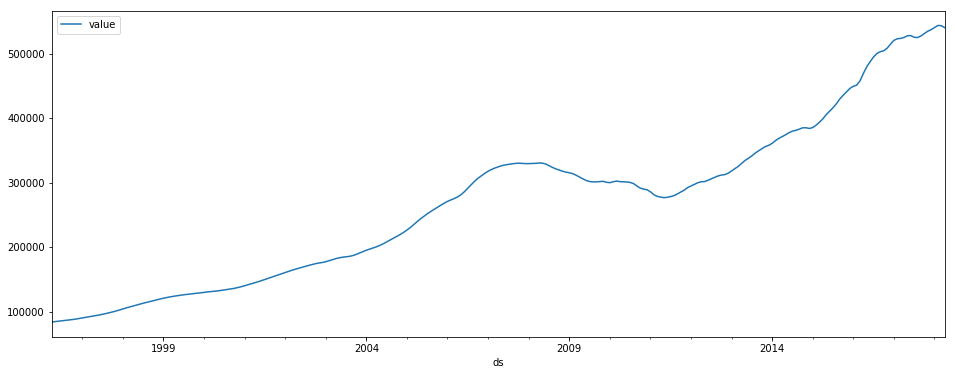

In [35]:
or_97227 = melt_data(or_97227)
or_97227.plot(figsize=(16,6));

# Modeling

## 97034

### Facebook Prophet

#### Train-test split

Because all the zipcodes took a hard dip during the recession, I want to make sure that my training set incorporates some of the upswing as the housing market exited the recession. For this reason, I will reserve the last 10% (2 years and 4 months) of the data for testing.

In [36]:
or_97034_train = or_97034[:'2015-12']
or_97034_test = or_97034['2015-12':]

In [37]:
or_97034_train.tail()

,value
ds,
2015-08-01,613300.0
2015-09-01,619000.0
2015-10-01,623200.0
2015-11-01,628200.0
2015-12-01,634300.0


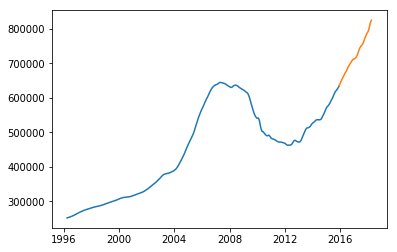

In [38]:
plt.plot(or_97034_train);
plt.plot(or_97034_test);

#### Modeling on train set

In [44]:
or_97034_train_fb = or_97034_train.reset_index()
or_97034_train_fb = or_97034_train_fb.rename(columns={'date':'ds','value':'y'})

In [45]:
or_97034_train_fb

,ds,y
0,1996-04-01,252000.0
1,1996-05-01,253000.0
2,1996-06-01,254100.0
3,1996-07-01,255200.0
4,1996-08-01,256600.0
...,...,...
232,2015-08-01,613300.0
233,2015-09-01,619000.0
234,2015-10-01,623200.0
235,2015-11-01,628200.0


In [46]:
model = proph(interval_width=0.95)

model.fit(or_97034_train_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [54]:
future = model.make_future_dataframe(periods=28, freq='MS')
future

,ds
0,1996-04-01
1,1996-05-01
2,1996-06-01
3,1996-07-01
4,1996-08-01
...,...
260,2017-12-01
261,2018-01-01
262,2018-02-01
263,2018-03-01


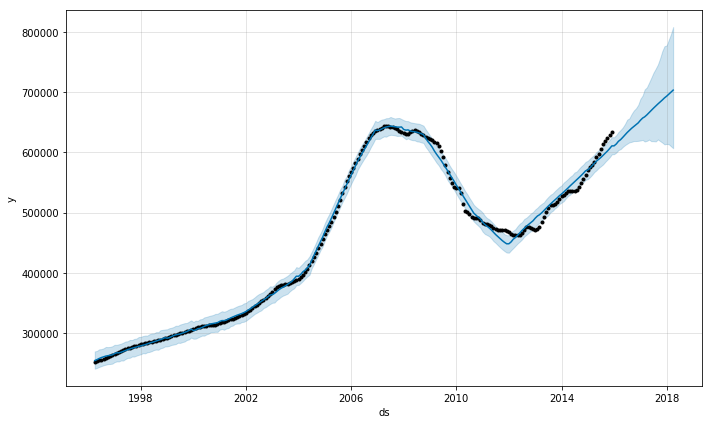

In [47]:
forecast = model.predict(future)

model.plot(forecast, uncertainty=True);

#### Modeling on test set

In [50]:
or_97034_test_fb = or_97034_test.reset_index()
or_97034_test_fb.columns = ['ds','y']
or_97034_test_fb

,ds,y
0,2015-12-01,634300.0
1,2016-01-01,642600.0
2,2016-02-01,650400.0
3,2016-03-01,656800.0
4,2016-04-01,663700.0
5,2016-05-01,670700.0
6,2016-06-01,676200.0
7,2016-07-01,683300.0
8,2016-08-01,690400.0
9,2016-09-01,696100.0


In [65]:
y_pred = model.predict(or_97034_test_fb.drop('y', axis=1))

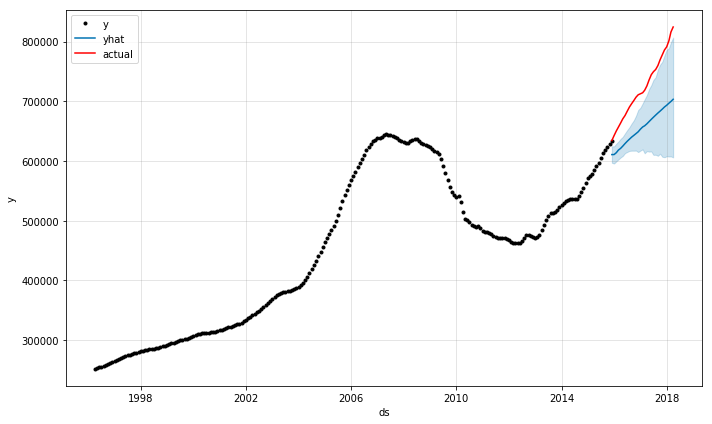

In [64]:
model.plot(y_pred, uncertainty=True)
plt.plot(or_97034_test, color='r', label='actual')
plt.legend();

In [68]:
mse = np.mean((y_pred.yhat - or_97034_test_fb['y'])**2)
print(mse)

5047503736.319287


In [69]:
np.sqrt(mse)

71045.786196785

#### Forecasting on whole set

In [71]:
or_97034.reset_index(inplace=True)
or_97034.columns = ['ds', 'y']
or_97034

,ds,y
0,1996-04-01,252000.0
1,1996-05-01,253000.0
2,1996-06-01,254100.0
3,1996-07-01,255200.0
4,1996-08-01,256600.0
...,...,...
260,2017-12-01,786100.0
261,2018-01-01,791300.0
262,2018-02-01,801700.0
263,2018-03-01,816200.0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



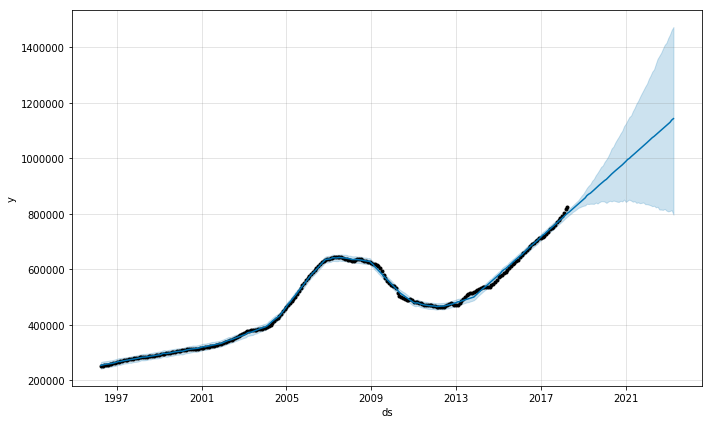

In [73]:
model2 = proph(interval_width=0.95)

model2.fit(or_97034)

future = model2.make_future_dataframe(periods=60, freq='MS')
forecast = model2.predict(future)

model2.plot(forecast, uncertainty=True);

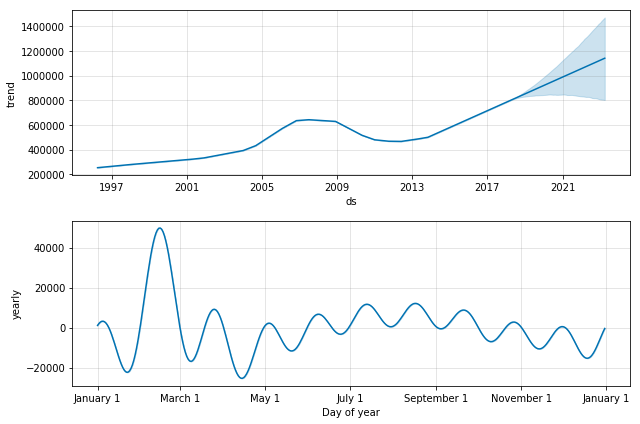

In [74]:
model2.plot_components(forecast);

### ARIMA? Or is this overkill?

## 97232

### Facebook Prophet

#### Train-test split

#### Modeling on train set

#### Modeling on test set

#### Forecasting on whole set

## 97210

### Facebook Prophet

#### Train-test split

#### Modeling on train set

#### Modeling on test set

#### Forecasting on whole set

## 97205

### Facebook Prophet

#### Train-test split

#### Modeling on train set

#### Modeling on test set

#### Forecasting on whole set

## 97227

### Facebook Prophet

#### Train-test split

#### Modeling on train set

#### Modeling on test set

#### Forecasting on whole set

# Interpretation